In [1]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

# Debug
import ipdb
deb = ipdb.set_trace

# General imports
import os
import sys
import datetime
import numpy as np

# MRI analysis imports
import nibabel as nb
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel
# from prfpy.fit import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

# Personal imports
sys.path.append("{}/../../analysis_code/utils".format(os.getcwd()))
from maths_utils import r2_score_surf
from settings_utils import load_settings
from screen_utils import get_screen_settings
from pycortex_utils import set_pycortex_config_file
from surface_utils import load_surface ,make_surface_image
from prfpy_utils import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

In [2]:
# Get inputs
start_time = datetime.datetime.now()

# Inputs
main_dir = '/Users/uriel/disks/meso_shared'
project_dir = 'bio7'
subject = 'sub-8761'
sub_num = subject[4:]
input_fn = '{}/{}/derivatives/pp_data/{}/fsnative/func/fmriprep_dct_z-score_avg/{}_task-retin_hemi-L_fmriprep_dct_z-score_avg_bold.func.gii'.format(main_dir, project_dir, subject, subject)
n_jobs = 32

n_batches = n_jobs
verbose = True
css_params_num = 9

In [3]:
# Load settings
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
settings_path = os.path.join(base_dir, project_dir, "settings.yml")
prf_settings_path = os.path.join(base_dir, project_dir, "prf-analysis.yml")
settings = load_settings([settings_path, prf_settings_path])
analysis_info = settings[0]

TR = analysis_info['TR']
gauss_grid_nr = analysis_info['gauss_grid_nr']
max_ecc_size = analysis_info['max_ecc_size']
n_th = analysis_info['n_th']
rsq_iterative_th = analysis_info['rsq_iterative_th']
css_grid_nr = analysis_info['css_grid_nr']
size_th = analysis_info['size_th']
prf_amp_th = analysis_info['prf_amp_th']


# TR = analysis_info['TR']
# gauss_grid_nr = analysis_info['gauss_grid_nr']
# max_ecc_size = 16
# n_th = analysis_info['n_th']
# rsq_iterative_th = 0.05
# css_grid_nr = analysis_info['css_grid_nr']
# size_th = [0.05, 16]
# prf_amp_th = [0, 3]


In [4]:
size_th

[0.05, 12]

In [5]:
# Load screen settings from subject dependend task-events.json
prf_task_name = input_fn.split("task-")[1].split("_")[0] # from the file path
screen_size_cm, screen_distance_cm = get_screen_settings(main_dir,project_dir, sub_num, prf_task_name)

print("\n===== PRF FIT PARAMETERS =====")
print(f"Screen Size (cm): {screen_size_cm}")
print(f"Screen Distance (cm): {screen_distance_cm}")
print(f"TR: {TR}")
print(f"Max eccentricity/size values: {max_ecc_size}")
print("==============================\n")

[INFO] Using screen info from /Users/uriel/disks/meso_shared/bio7/sub-8761/ses-02/sub-8762_ses-02_task-retin_events.json
[INFO] Screen size: [64.84, 39.29] cm, distance: 154.0 cm

===== PRF FIT PARAMETERS =====
Screen Size (cm): [64.84, 39.29]
Screen Distance (cm): 154.0
TR: 1.6
Max eccentricity/size values: 12



In [6]:
# Set pycortex db and colormaps
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
set_pycortex_config_file(cortex_dir)

In [7]:
# Define directories and files names (fn)
if input_fn.endswith('.nii'):
    prf_fit_dir = "{}/{}/derivatives/pp_data/{}/170k/prf/fit".format(
        main_dir, project_dir, subject)
    os.makedirs(prf_fit_dir, exist_ok=True)

elif input_fn.endswith('.gii'):
    prf_fit_dir = "{}/{}/derivatives/pp_data/{}/fsnative/prf/fit".format(
        main_dir, project_dir, subject)
    os.makedirs(prf_fit_dir, exist_ok=True)

css_fit_fn = input_fn.split('/')[-1]
css_fit_fn = css_fit_fn.replace('bold', 'prf-css_fit')

css_pred_fn = input_fn.split('/')[-1] 
css_pred_fn = css_pred_fn.replace('bold', 'prf-css_pred')

# Get task specific visual design matrix
vdm_fn = '{}/{}/derivatives/vdm/task-{}_vdm.npy'.format(
    main_dir, project_dir, prf_task_name)
vdm = np.load(vdm_fn)

In [8]:
# Define model parameter grid range
sizes = max_ecc_size * np.linspace(0.1, 1, gauss_grid_nr)**2
eccs = max_ecc_size * np.linspace(0.1, 1, gauss_grid_nr)**2
polars = np.linspace(0, 2 * np.pi, gauss_grid_nr)
exponent_css_grid = np.linspace(n_th[0], n_th[1], css_grid_nr)

In [41]:
# Load data
img, data = load_surface(fn=input_fn)

# Exclude vertices with all-NaN timeseries to avoid errors during fitting
valid_vertices = ~np.isnan(data).any(axis=0)
valid_vertices_idx = np.where(valid_vertices)[0]

# Filter data to only include valid vertices
data_clean = data[:, valid_vertices]

n_excluded = data.shape[1] - data_clean.shape[1]
if n_excluded > 0:
    print(f"Excluded {n_excluded} vertices with all-NaN values")
print(f"Fitting {valid_vertices.sum()} valid vertices")

Excluded 8462 vertices with all-NaN values
Fitting 128203 valid vertices


In [40]:
data.shape[1]

136665

In [38]:
len(valid_vertices_idx)

128203

In [10]:
# Determine visual design
stimulus = PRFStimulus2D(screen_size_cm=screen_size_cm[1],
                         screen_distance_cm=screen_distance_cm,
                         design_matrix=vdm, 
                         TR=TR)

print("\n===== PRF MODEL PARAMETERS =====")
print("Stimulus x min/max (deg):", np.nanmin(stimulus.x_coordinates ), np.nanmax(stimulus.x_coordinates ))
print("Stimulus y min/max (deg):", np.nanmin(stimulus.y_coordinates), np.nanmax(stimulus.y_coordinates))
print("Eccentricity grid range:", np.min(eccs), np.max(eccs))
print("CSS exponent grid:", exponent_css_grid)
print("Size grid range:", np.min(sizes), np.max(sizes))
print("==============================\n")


===== PRF MODEL PARAMETERS =====
Stimulus x min/max (deg): -7.2696694083413425 7.2696694083413425
Stimulus y min/max (deg): -7.2696694083413425 7.2696694083413425
Eccentricity grid range: 0.12000000000000002 12.0
CSS exponent grid: [0.01 0.12 0.23 0.34 0.45 0.56 0.67 0.78 0.89 1.  ]
Size grid range: 0.12000000000000002 12.0



In [11]:
# Gauss fit
# ---------
gauss_bounds = [(-max_ecc_size, max_ecc_size),  # x
                (-max_ecc_size, max_ecc_size),  # y
                (size_th[0], size_th[1]),  # prf size
                (prf_amp_th[0], prf_amp_th[1]), # prf amplitude
                (-1, 1),# bold baseline
                (0, 10),  # hrf1
                (0, 0) # hrf2
                ]  
print("\n===== PRF FIT BOUNDS =====")
print("Gauss bounds:")
print("  x range:", gauss_bounds[0])
print("  y range:", gauss_bounds[1])
print("  prf size range:", gauss_bounds[2])
print("  prf amplitude range:", gauss_bounds[3])
print("  bold baseline range:", gauss_bounds[4])
print("  hrf1 range:", gauss_bounds[5])
print("  hrf2 range:", gauss_bounds[6])


===== PRF FIT BOUNDS =====
Gauss bounds:
  x range: (-12, 12)
  y range: (-12, 12)
  prf size range: (0.05, 12)
  prf amplitude range: (0, 6)
  bold baseline range: (-1, 1)
  hrf1 range: (0, 10)
  hrf2 range: (0, 0)


In [12]:
# CSS fit
# -------
css_bounds = [(-max_ecc_size, max_ecc_size),  # x
              (-max_ecc_size, max_ecc_size),  # y
              (size_th[0], size_th[1]),  # prf size
              (prf_amp_th[0], prf_amp_th[1]), # prf amplitude
              (-1, 1),  # bold baseline 
              (n_th[0], n_th[1]),  # n
              (0, 10),  # hrf1
              (0, 0) # hrf2
              ] 

print("\nCSS bounds:")
print("  x range:", css_bounds[0])
print("  y range:", css_bounds[1])
print("  prf size range:", css_bounds[2])
print("  prf amplitude range:", css_bounds[3])
print("  bold baseline range:", css_bounds[4])
print("  n exponent range:", css_bounds[5])
print("  hrf1 range:", css_bounds[6])
print("  hrf2 range:", css_bounds[7])
print("==========================\n")


CSS bounds:
  x range: (-12, 12)
  y range: (-12, 12)
  prf size range: (0.05, 12)
  prf amplitude range: (0, 6)
  bold baseline range: (-1, 1)
  n exponent range: (0.01, 1)
  hrf1 range: (0, 10)
  hrf2 range: (0, 0)



In [13]:
# Define gauss model
gauss_model = Iso2DGaussianModel(stimulus=stimulus)

# Grid fit gauss model
gauss_fitter = Iso2DGaussianFitter(data=data.T, 
                                   model=gauss_model, 
                                   n_jobs=n_jobs)

gauss_fitter.grid_fit(ecc_grid=eccs, 
                      polar_grid=polars, 
                      size_grid=sizes, 
                      verbose=False, 
                      n_batches=n_batches)

# Iterative fit gauss model
gauss_fitter.iterative_fit(rsq_threshold=rsq_iterative_th, 
                           bounds=gauss_bounds,
                           verbose=False)
gauss_fit = gauss_fitter.iterative_search_params

/Users/uriel/disks/meso_H/projects/pRF_analysis/RetinoMaps/dev/../../analysis_code/utils/prfpy_utils.py:441: RuntimeWarning: divide by zero encountered in divide
  slopes = (n_timepoints * np.dot(vox_data, predictions.T) - sumd *
/Users/uriel/disks/meso_H/projects/pRF_analysis/RetinoMaps/dev/../../analysis_code/utils/prfpy_utils.py:441: RuntimeWarning: invalid value encountered in divide
  slopes = (n_timepoints * np.dot(vox_data, predictions.T) - sumd *
/Users/uriel/disks/meso_H/projects/pRF_analysis/RetinoMaps/dev/../../analysis_code/utils/prfpy_utils.py:441: RuntimeWarning: divide by zero encountered in divide
  slopes = (n_timepoints * np.dot(vox_data, predictions.T) - sumd *
/Users/uriel/disks/meso_H/projects/pRF_analysis/RetinoMaps/dev/../../analysis_code/utils/prfpy_utils.py:441: RuntimeWarning: invalid value encountered in divide
  slopes = (n_timepoints * np.dot(vox_data, predictions.T) - sumd *
/Users/uriel/disks/meso_H/projects/pRF_analysis/RetinoMaps/dev/../../analysis_code

In [14]:
# Define CSS model
css_model = CSS_Iso2DGaussianModel(stimulus=stimulus)

# Grid fit CSS model
css_fitter = CSS_Iso2DGaussianFitter(data=data.T, 
                                     model=css_model, 
                                     n_jobs=n_jobs,
                                     use_previous_gaussian_fitter_hrf=False,
                                     previous_gaussian_fitter=gauss_fitter)

In [15]:
# Run css grid fit
css_fitter.grid_fit(exponent_grid=exponent_css_grid,
                    verbose=verbose,
                    n_batches=n_batches)

Each batch contains approx. 3962 voxels.


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
/Users/uriel/disks/meso_H/projects/pRF_analysis/RetinoMaps/dev/../../analysis_code/utils/prfpy_utils.py:833: RuntimeWarning: invalid value encountered in divide
  slopes = (n_timepoints * np.dot(vox_data, predictions.T) - sumd *
/Users/uriel/disks/meso_H/projects/pRF_analysis/RetinoMaps/dev/../../analysis_code/utils/prfpy_utils.py:833: RuntimeWarning: divide by zero encountered in divide
  slopes = (n_timepoints * np.dot(vox_data, predictions.T) - sumd *
/Users/uriel/disks/meso_H/projects/pRF_analysis/RetinoMaps/dev/../../analysis_code/utils/prfpy_utils.py:841: RuntimeWarning: invalid value encountered in subtract
  resid = np.linalg.norm((vox_data -
/Users/uriel/disks/meso_H/projects/pRF_analysis/RetinoMaps/dev/../../analysis_code/utils/prfpy_utils.py:833: RuntimeWarning: invalid value encountered in divide
  slopes = (n_timepoints * np.dot(vox_data, predictions.T) - sumd *
/Users/uriel/disks/meso_H/projects/

In [ ]:
# Run iterative fit
css_fitter.iterative_fit(rsq_threshold=rsq_iterative_th, 
                         verbose=verbose, 
                         bounds=css_bounds,
                         xtol=1e-4, 
                         ftol=1e-4)

css_fit = css_fitter.iterative_search_params

In [26]:
# Rearrange result of CSS model
css_fit_mat = np.full((data.shape[1], css_params_num), np.nan, dtype=float)
css_pred_mat = np.full_like(data, np.nan, dtype=float) 

for est, vert in enumerate(valid_vertices_idx):
    css_fit_mat[vert] = css_fit[est]
    css_pred_mat[:,vert] = css_model.return_prediction(mu_x=css_fit[est][0],
                                                      mu_y=css_fit[est][1], 
                                                      size=css_fit[est][2], 
                                                      beta=css_fit[est][3], 
                                                      baseline=css_fit[est][4],
                                                      n=css_fit[est][5],
                                                      hrf_1=css_fit[est][6], 
                                                       hrf_2=css_fit[est][7])

IndexError: index 128203 is out of bounds for axis 0 with size 128203

In [24]:
                                                      
if 'loo-avg' in input_fn:
    # Compute loo r2
    loo_bold_fn = input_fn.replace('loo-avg-', 'loo-')
    loo_img, loo_bold = load_surface(fn=loo_bold_fn)
    loo_r2 = r2_score_surf(bold_signal=loo_bold, model_prediction=css_pred_mat)
    
    # Add loo r2 css_fit_mat
    css_fit_mat = np.column_stack((css_fit_mat, loo_r2))

    # Export data
    maps_names = ['mu_x', 'mu_y', 'prf_size', 'prf_amplitude', 'bold_baseline',
                  'n', 'hrf_1','hrf_2', 'r_squared', 'loo_r_squared']
    
else:
    # Export data from CSS model fit
    maps_names = ['mu_x', 'mu_y', 'prf_size', 'prf_amplitude', 'bold_baseline',
                  'n', 'hrf_1', 'hrf_2', 'r_squared']
    
# Export fit
img_css_fit_mat = make_surface_image(data=css_fit_mat.T, source_img=img, maps_names=maps_names)
nb.save(img_css_fit_mat,'{}/{}'.format(prf_fit_dir, css_fit_fn))

# Export prediction
img_css_pred_mat = make_surface_image(data=css_pred_mat, source_img=img)
nb.save(img_css_pred_mat,'{}/{}'.format(prf_fit_dir, css_pred_fn))

# Print duration
end_time = datetime.datetime.now()
print("\nStart time:\t{start_time}\nEnd time:\t{end_time}\nDuration:\t{dur}".format(start_time=start_time, 
                                                                                    end_time=end_time, 
                                                                                    dur=end_time - start_time))


Start time:	2026-02-18 16:10:30.515299
End time:	2026-02-18 16:39:00.108240
Duration:	0:28:29.592941


In [25]:
maps_names

['mu_x',
 'mu_y',
 'prf_size',
 'prf_amplitude',
 'bold_baseline',
 'n',
 'hrf_1',
 'hrf_2',
 'r_squared']

# Explore

In [16]:
max_indices = np.argmin(data, axis=0)

print(max_indices.shape)  # (128203,)
print(max_indices[:10])   # indices des 10 premières colonnes

(128203,)
[118 118   2   2 118  34 118 118 118 118]


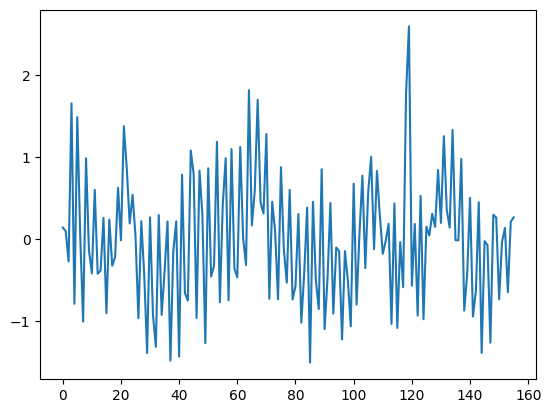

In [17]:
import matplotlib.pyplot as plt
plt.plot(data[:, max_indices[0]])

In [29]:
np.min(gauss_fit[:,-1])

-2.2113141744803806

In [23]:
np.sum(gauss_fitter.rsq_mask)

78501

In [25]:
gauss_fitter.

(46656, 156)